# Bloc Exploration & Analysis

This notebook explores all political blocs in the Squares public data using the centralized `bloc_config.json` configuration.

## Bloc Matching Criteria

Users are assigned to a bloc if they meet BOTH conditions:
1. **Key Dimension Match**: Within 1.5 points on at least 2 of the bloc's key dimensions (most important ideological markers)
2. **Overall Distance**: Euclidean distance < 4.0 across all 5 dimensions (prevents false positives)

## Blocs Analyzed

All 13 blocs from the configuration:
- **Playable Blocs**: Social Democrat Union, Postscarcity Syndicate, Nordic Model, Builder Bloc, Abundance Alliance, Libertarian Lobby, Liberty Caucus, Localist League, NatCon Corps, Postliberal Front
- **Reference Ideologies**: Communists, Revolutionary Socialists, Fascists

## Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from supabase import create_client, Client

# Load environment variables
load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env.development.local'))

# Set up plotting
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize Supabase
url = os.environ.get('NEXT_PUBLIC_SUPABASE_URL')
key = os.environ.get('NEXT_PUBLIC_SUPABASE_ANON_KEY')
if not url or not key:
    raise ValueError('Missing Supabase credentials')
supabase = create_client(url, key)
print('✅ Setup complete')

✅ Setup complete


## Load Data

In [2]:
# Query public spectrum data
response = supabase.table('public_farcaster_spectrums').select('*').execute()
df = pd.DataFrame(response.data)
print(f'Loaded {len(df)} user spectrums')
print(f'Columns: {list(df.columns)}')
df.head()

Loaded 91 user spectrums
Columns: ['id', 'fid', 'username', 'display_name', 'pfp_url', 'trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score', 'times_updated', 'created_at', 'updated_at', 'divergence_score', 'spread_score']


,id,fid,username,display_name,pfp_url,trade_score,abortion_score,migration_score,economics_score,rights_score,times_updated,created_at,updated_at,divergence_score,spread_score
0,72155d93-e59f-4f09-acc5-b610eaa57219,427926,queenresearch.eth,Miseryu,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,3,0,5,3,4,3,2025-10-21T11:20:02.180218+00:00,2025-10-21T11:21:04.450484+00:00,1.673320,1.673320
1,0e24cc38-7949-4a74-8449-7b8935694551,1385181,mitdralla.base.eth,mitdralla,https://res.cloudinary.com/base-app/image/uplo...,2,2,1,4,2,2,2025-10-21T05:50:52.128857+00:00,2025-10-21T05:51:05.17724+00:00,1.264911,0.979796
2,2a1df2ee-b9a4-4d14-8b8a-191d3bbe9460,352478,chronor,chronor,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,1,5,2,3,2,2025-10-19T04:17:30.366141+00:00,2025-10-19T04:18:17.674107+00:00,1.897367,1.720465
3,a0b43a0c-c5ef-4426-8d7a-a01506b0ab3b,392746,0wn,0x0 🎩🔵,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,0,0,0,0,2,2025-10-18T09:58:22.936647+00:00,2025-10-18T09:58:31.269215+00:00,3.000000,0.000000
4,9b53aedd-caea-474a-9c35-1bb9b5288aa5,797945,t9let,T9LET,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,3,4,3,3,0,3,2025-10-18T03:52:37.945627+00:00,2025-10-18T03:55:32.386276+00:00,1.414214,1.356466


## Bloc Definitions from Config

Display all bloc ideal positions and key dimensions from the configuration.

In [3]:
# Import bloc configuration from JSON loader
sys.path.append(os.path.dirname(os.getcwd()))
from analytics.bloc_config_loader import (
    BLOC_NAMES, BLOC_DESCRIPTIONS, IDEAL_BLOC_POSITIONS, 
    BLOC_KEY_DIMENSIONS, get_all_blocs
)

print('✅ Bloc configuration loaded')

✅ Bloc configuration loaded


### Display All Bloc Definitions

Show ideal positions and key dimensions for all blocs from the configuration.

In [4]:
# Display bloc definitions
print("=" * 80)
print("BLOC DEFINITIONS FROM CONFIG")
print("=" * 80)

for bloc_id in get_all_blocs(include_reference=True):
    bloc_name = BLOC_NAMES.get(bloc_id, bloc_id)
    desc = BLOC_DESCRIPTIONS.get(bloc_id, "")
    ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
    key_dims = BLOC_KEY_DIMENSIONS[bloc_id]
    
    # Format ideal position as [T,A,M,E,R]
    pos_str = f"[{ideal_pos['trade_score']}, {ideal_pos['abortion_score']}, {ideal_pos['migration_score']}, {ideal_pos['economics_score']}, {ideal_pos['rights_score']}]"
    
    print(f"\n{bloc_name}")
    print(f"  Ideal: {pos_str}")
    print(f"  Key Dimensions: {', '.join(key_dims)}")
    print(f"  Description: {desc}")

print(f"\n{'=' * 80}")
print(f"Total: {len(get_all_blocs(include_reference=True))} blocs")
print(f"{'=' * 80}")

BLOC DEFINITIONS FROM CONFIG

Communists
  Ideal: [6, 1, 1, 6, 5]
  Key Dimensions: economics, rights, trade
  Description: Marxist-Leninist vanguard. Centrally planned economy, abolition of private property, dictatorship of the proletariat.

Revolutionary Socialists
  Ideal: [5, 0, 1, 6, 2]
  Key Dimensions: economics, rights, trade
  Description: Anti-capitalist left. Worker control of production, abolish capitalism via mass movements, democratic socialism with revolutionary aims.

Social Democrat Union
  Ideal: [5, 0, 2, 5, 0]
  Key Dimensions: economics, trade, rights
  Description: Protectionist social democrats. Labor-focused, anti-free trade, pro-choice, extensive redistribution, progressive rights.

Postscarcity Syndicate
  Ideal: [1, 0, 0, 5, 0]
  Key Dimensions: economics, migration, rights
  Description: Tech-optimist left. Open borders, heavy economic intervention (UBI, automation support), very progressive on social issues.

Nordic Model
  Ideal: [1, 0, 3, 4, 1]
  Key Dime

### Calculate Bloc Memberships

Apply matching algorithm to assign users to blocs.

In [5]:
dimensions = ['trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score']

def get_scores(row):
    return [row[dim] for dim in dimensions]

# Dynamic bloc membership function using config
# Matching criteria:
# 1. Must be within 1.5 points on at least 2 of the bloc's key dimensions
# 2. Overall Euclidean distance must be < 4.0 to avoid false positives

def belongs_to_bloc(row, bloc_id):
    """Check if user belongs to a bloc based on ideal positions and key dimensions"""
    ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
    key_dims = BLOC_KEY_DIMENSIONS[bloc_id]
    
    # Map dimension names to score fields
    dim_map = {
        'trade': 'trade_score',
        'abortion': 'abortion_score',
        'migration': 'migration_score',
        'economics': 'economics_score',
        'rights': 'rights_score',
    }
    
    # Count how many key dimensions are close
    close_count = 0
    for dim in key_dims:
        score_field = f'{dim}_score'
        user_score = row[dim_map[dim]]
        ideal_score = ideal_pos[score_field]
        # Within 1.5 points is considered close
        if abs(user_score - ideal_score) <= 1.5:
            close_count += 1
    
    # Check overall Euclidean distance across all 5 dimensions
    sum_squared_diffs = 0
    for dim in ['trade', 'abortion', 'migration', 'economics', 'rights']:
        score_field = f'{dim}_score'
        user_score = row[dim_map[dim]]
        ideal_score = ideal_pos[score_field]
        sum_squared_diffs += (user_score - ideal_score) ** 2
    
    euclidean_distance = np.sqrt(sum_squared_diffs)
    
    # Match if close on at least 2 key dimensions AND overall distance is reasonable
    return close_count >= 2 and euclidean_distance < 4.0

# Apply memberships for all blocs
bloc_ids = get_all_blocs(include_reference=True)
for bloc_id in bloc_ids:
    df[bloc_id] = df.apply(lambda row: belongs_to_bloc(row, bloc_id), axis=1)

bloc_columns = bloc_ids
print(f'✅ Bloc memberships calculated ({len(bloc_columns)} blocs)')

✅ Bloc memberships calculated (13 blocs)


## Near Miss Analysis

Exploring users who were close to bloc membership (2 out of 3 required dimensions)

NEAR MISS ANALYSIS

📌 Users with 1/2 required key dimensions per bloc:

                    Bloc  Near Misses
            Builder Bloc           25
      Abundance Alliance           22
Revolutionary Socialists           10
            Nordic Model           10
          Liberty Caucus           10
  Postscarcity Syndicate            9
   Social Democrat Union            8
       Libertarian Lobby            6
         Localist League            6
                Fascists            2
              Communists            1
            NatCon Corps            1
       Postliberal Front            0

🎯 Users with multiple near misses: 64

📋 Top 10 users closest to multiple blocs:

          username  total_near_misses  trade_score  abortion_score  migration_score  economics_score  rights_score
      abcryptozone                  5            0               2                3                3             0
    augustuscaesar                  4            0               0                3

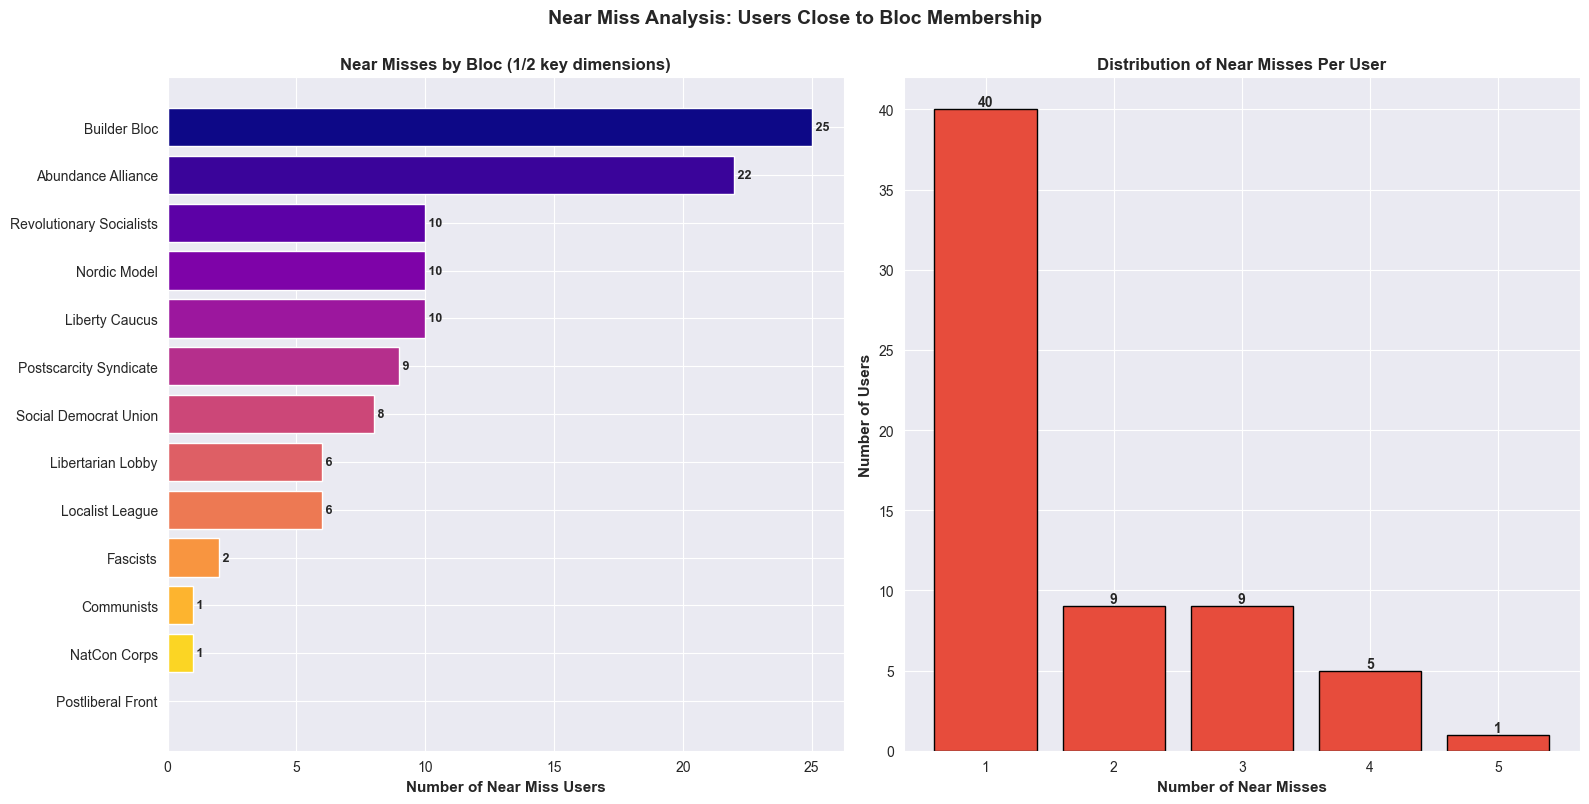


✅ Near miss analysis complete!


In [6]:
# Calculate near misses for each bloc
# Near miss: close on exactly 1 key dimension (instead of required 2)
# AND overall distance < 5.0 (slightly relaxed from 4.0)

near_miss_data = []
near_miss_cols = []

for bloc_id in bloc_ids:
    ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
    key_dims = BLOC_KEY_DIMENSIONS[bloc_id]
    bloc_name = BLOC_NAMES.get(bloc_id, bloc_id)
    
    # Map dimension names to score fields  
    dim_map = {
        'trade': 'trade_score',
        'abortion': 'abortion_score',
        'migration': 'migration_score',
        'economics': 'economics_score',
        'rights': 'rights_score',
    }
    
    def is_near_miss(row):
        if row[bloc_id]:  # Already a member
            return False
            
        # Count close key dimensions
        close_count = 0
        for dim in key_dims:
            score_field = f'{dim}_score'
            user_score = row[dim_map[dim]]
            ideal_score = ideal_pos[score_field]
            if abs(user_score - ideal_score) <= 1.5:
                close_count += 1
        
        # Calculate overall distance
        sum_squared_diffs = 0
        for dim in ['trade', 'abortion', 'migration', 'economics', 'rights']:
            score_field = f'{dim}_score'
            user_score = row[dim_map[dim]]
            ideal_score = ideal_pos[score_field]
            sum_squared_diffs += (user_score - ideal_score) ** 2
        euclidean_distance = np.sqrt(sum_squared_diffs)
        
        # Near miss: close on 1 key dimension with reasonable distance
        return close_count == 1 and euclidean_distance < 5.0
    
    col_name = f'{bloc_id}_near'
    df[col_name] = df.apply(is_near_miss, axis=1)
    near_miss_cols.append(col_name)
    near_miss_count = df[col_name].sum()
    near_miss_data.append((bloc_name, near_miss_count))

# Create DataFrame
near_miss_df = pd.DataFrame(near_miss_data, columns=['Bloc', 'Near Misses'])
near_miss_df = near_miss_df.sort_values('Near Misses', ascending=False)

print("=" * 70)
print("NEAR MISS ANALYSIS")
print("=" * 70)
print("\n📌 Users with 1/2 required key dimensions per bloc:\n")
print(near_miss_df.to_string(index=False))

# Find users with most near misses
df['total_near_misses'] = df[near_miss_cols].sum(axis=1)

users_with_near_misses = df[df['total_near_misses'] > 0][['username', 'total_near_misses'] + dimensions].sort_values('total_near_misses', ascending=False)

print(f"\n🎯 Users with multiple near misses: {len(users_with_near_misses)}")
if len(users_with_near_misses) > 0:
    print(f"\n📋 Top 10 users closest to multiple blocs:\n")
    print(users_with_near_misses.head(10).to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Near misses by bloc (top 15 for readability)
top_near_misses = near_miss_df.head(15)
colors = plt.cm.plasma(np.linspace(0, 1, len(top_near_misses)))
bars = ax1.barh(top_near_misses['Bloc'], top_near_misses['Near Misses'], color=colors)
ax1.set_xlabel('Number of Near Miss Users', fontsize=11, fontweight='bold')
ax1.set_title('Near Misses by Bloc (1/2 key dimensions)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
for bar in bars:
    width = bar.get_width()
    if width > 0:
        ax1.text(width, bar.get_y() + bar.get_height()/2., f' {int(width)}', 
                ha='left', va='center', fontsize=9, fontweight='bold')

# Distribution of total near misses per user
if (df['total_near_misses'] > 0).any():
    near_miss_dist = df[df['total_near_misses'] > 0]['total_near_misses'].value_counts().sort_index()
    ax2.bar(near_miss_dist.index, near_miss_dist.values, color='#e74c3c', edgecolor='black')
    ax2.set_xlabel('Number of Near Misses', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
    ax2.set_title('Distribution of Near Misses Per User', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(1, int(near_miss_dist.index.max()) + 1))
    for i, v in enumerate(near_miss_dist.values):
        ax2.text(near_miss_dist.index[i], v, str(v), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Near Miss Analysis: Users Close to Bloc Membership', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n✅ Near miss analysis complete!")

### Detailed Near Miss Examples

Examining specific users and which dimensions they're missing

In [7]:
# Detailed breakdown of near misses by bloc
def get_dimension_details(row, bloc_id):
    """Returns which key dimensions are in range and which are out"""
    ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
    key_dims = BLOC_KEY_DIMENSIONS[bloc_id]
    
    dim_map = {
        'trade': 'trade_score',
        'abortion': 'abortion_score',
        'migration': 'migration_score',
        'economics': 'economics_score',
        'rights': 'rights_score',
    }
    
    in_range = []
    out_range = []
    
    for dim in key_dims:
        score_field = f'{dim}_score'
        user_score = row[dim_map[dim]]
        ideal_score = ideal_pos[score_field]
        diff = abs(user_score - ideal_score)
        
        if diff <= 1.5:
            in_range.append(f"{dim}={user_score} (ideal={ideal_score})")
        else:
            out_range.append(f"{dim}={user_score} (ideal={ideal_score}, diff={diff:.1f})")
    
    return in_range, out_range

print("=" * 70)
print("DETAILED NEAR MISS EXAMPLES")
print("=" * 70)

# Function to show examples for a bloc
def show_bloc_near_misses(bloc_id, bloc_name, near_miss_col, max_examples=3):
    near_users = df[df[near_miss_col] == True][['username'] + dimensions].head(max_examples)
    
    if len(near_users) > 0:
        ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
        ideal_str = f"[{ideal_pos['trade_score']}, {ideal_pos['abortion_score']}, {ideal_pos['migration_score']}, {ideal_pos['economics_score']}, {ideal_pos['rights_score']}]"
        key_dims = ', '.join(BLOC_KEY_DIMENSIONS[bloc_id])
        
        print(f"\n{'='*70}")
        print(f"🎯 {bloc_name}")
        print(f"   Ideal: {ideal_str} | Key dims: {key_dims}")
        print(f"{'='*70}")
        
        for idx, row in near_users.iterrows():
            in_range, out_range = get_dimension_details(row, bloc_id)
            print(f"\n👤 {row['username']}")
            print(f"   ✅ In range ({len(in_range)}): {', '.join(in_range)}")
            print(f"   ❌ Out of range ({len(out_range)}): {', '.join(out_range)}")

# Show examples for blocs with most near misses (top 8)
top_blocs = near_miss_df.head(8)
for _, row in top_blocs.iterrows():
    bloc_name = row['Bloc']
    # Find bloc_id from name
    bloc_id = next((bid for bid, bname in BLOC_NAMES.items() if bname == bloc_name), None)
    if bloc_id:
        near_miss_col = f'{bloc_id}_near'
        show_bloc_near_misses(bloc_id, bloc_name, near_miss_col, max_examples=3)

print(f"\n{'='*70}")
print("✅ Detailed examples complete!")
print(f"{'='*70}")

DETAILED NEAR MISS EXAMPLES

🎯 Builder Bloc
   Ideal: [2, 1, 1, 3, 1] | Key dims: economics, migration, trade

👤 0wn
   ✅ In range (1): migration=0 (ideal=1)
   ❌ Out of range (2): economics=0 (ideal=3, diff=3.0), trade=0 (ideal=2, diff=2.0)

👤 brennuet
   ✅ In range (1): migration=0 (ideal=1)
   ❌ Out of range (2): economics=5 (ideal=3, diff=2.0), trade=4 (ideal=2, diff=2.0)

👤 kiowayyy
   ✅ In range (1): migration=0 (ideal=1)
   ❌ Out of range (2): economics=0 (ideal=3, diff=3.0), trade=0 (ideal=2, diff=2.0)

🎯 Abundance Alliance
   Ideal: [0, 2, 0, 1, 1] | Key dims: trade, migration, economics

👤 mitdralla.base.eth
   ✅ In range (1): migration=1 (ideal=0)
   ❌ Out of range (2): trade=2 (ideal=0, diff=2.0), economics=4 (ideal=1, diff=3.0)

👤 hengky420
   ✅ In range (1): trade=0 (ideal=0)
   ❌ Out of range (2): migration=2 (ideal=0, diff=2.0), economics=3 (ideal=1, diff=2.0)

👤 thumbsup.eth
   ✅ In range (1): migration=0 (ideal=0)
   ❌ Out of range (2): trade=2 (ideal=0, diff=2.0), ec

### Orphaned Users Analysis

Examining users with no bloc membership and their near-miss status

ORPHANED USERS ANALYSIS

📊 Total orphaned users: 16
   • With near misses: 11
   • Without near misses: 5

🎯 Orphaned users who nearly qualified:

         username  total_near_misses  trade_score  abortion_score  migration_score  economics_score  rights_score
      hiponax.eth                  3            3               1                3                0             0
      lorenzo-007                  3            3               0                3                0             0
              meb                  2            2               5                5                2             2
queenresearch.eth                  1            3               0                5                3             4
 jshaner.base.eth                  1            4               5                3                2             0
      kingmodaser                  1            3               0                0                4             6
          leadgen                  1            0      

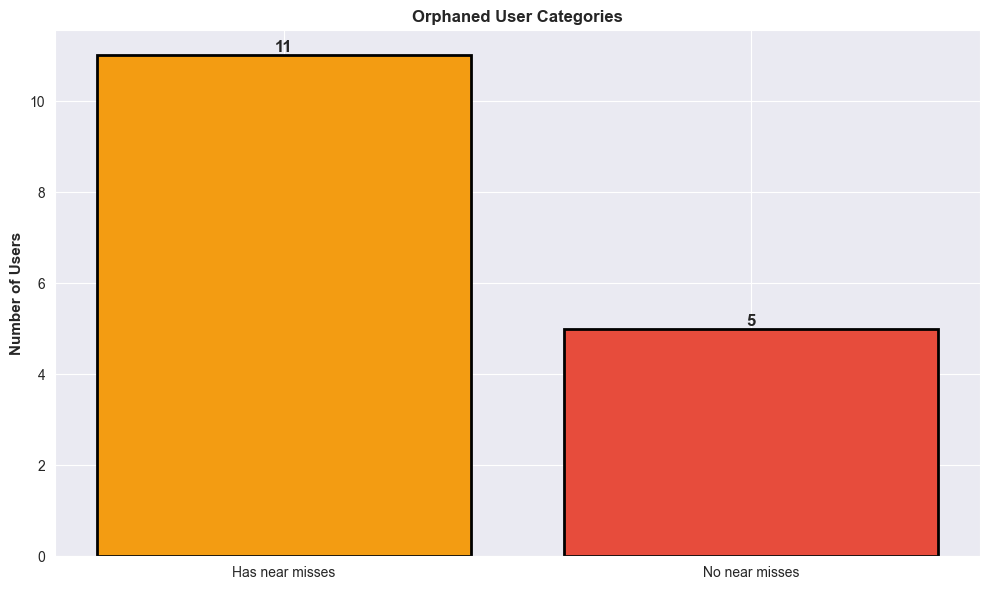


✅ Orphaned users analysis complete!


In [8]:
# Analyze orphaned users
# Ensure required columns exist
if 'in_any_bloc' not in df.columns:
    df['in_any_bloc'] = df[bloc_columns].any(axis=1)
if 'bloc_count' not in df.columns:
    df['bloc_count'] = df[bloc_columns].sum(axis=1)

orphaned_users = df[~df['in_any_bloc']][['username', 'total_near_misses'] + dimensions + near_miss_cols]

print("=" * 70)
print("ORPHANED USERS ANALYSIS")
print("=" * 70)
print(f"\n📊 Total orphaned users: {len(orphaned_users)}")
print(f"   • With near misses: {(orphaned_users['total_near_misses'] > 0).sum()}")
print(f"   • Without near misses: {(orphaned_users['total_near_misses'] == 0).sum()}")

orphaned_with_near_miss = orphaned_users[orphaned_users['total_near_misses'] > 0]
if len(orphaned_with_near_miss) > 0:
    print(f"\n🎯 Orphaned users who nearly qualified:\n")
    display_cols = ['username', 'total_near_misses', 'trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score']
    print(orphaned_with_near_miss[display_cols].sort_values('total_near_misses', ascending=False).to_string(index=False))
    
    # Show which blocs they nearly qualified for
    print(f"\n📋 Specific near-miss blocs for orphaned users:\n")
    for idx, row in orphaned_with_near_miss.iterrows():
        near_blocs = []
        for bloc_id in bloc_ids:
            near_miss_col = f'{bloc_id}_near'
            if row[near_miss_col]:
                bloc_name = BLOC_NAMES.get(bloc_id, bloc_id)
                near_blocs.append(bloc_name)
        
        if near_blocs:
            print(f"   • {row['username']}: {', '.join(near_blocs)}")

orphaned_no_near_miss = orphaned_users[orphaned_users['total_near_misses'] == 0]
if len(orphaned_no_near_miss) > 0:
    print(f"\n❌ Truly orphaned users (no near misses):\n")
    print(orphaned_no_near_miss[display_cols].to_string(index=False))

# Visualize orphaned user categories
fig, ax = plt.subplots(figsize=(10, 6))
orphan_categories = {
    'Has near misses': (orphaned_users['total_near_misses'] > 0).sum(),
    'No near misses': (orphaned_users['total_near_misses'] == 0).sum()
}
colors = ['#f39c12', '#e74c3c']
bars = ax.bar(orphan_categories.keys(), orphan_categories.values(), color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax.set_title('Orphaned User Categories', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("✅ Orphaned users analysis complete!")
print(f"{'='*70}")

### Orphaned Users: Bloc Positioning

Showing which blocs each orphaned user fits between on the political spectrum

ORPHANED USERS: BLOC POSITIONING ANALYSIS

📍 Showing which blocs each orphaned user fits between\n
   (Displaying closest 3 blocs for each user)
\n👤 queenresearch.eth [T=3, A=0, M=5, E=3, R=4]
   Positioned between:
      1. Nordic Model              (distance: 4.24, ideal: [1,0,3,4,1])
      2. Localist League           (distance: 4.47, ideal: [5,4,5,3,4])
      3. Builder Bloc              (distance: 5.20, ideal: [2,1,1,3,1])
\n👤 grentea100 [T=0, A=5, M=4, E=1, R=0]
   Positioned between:
      1. Liberty Caucus            (distance: 4.24, ideal: [0,4,3,1,4])
      2. Abundance Alliance        (distance: 5.10, ideal: [0,2,0,1,1])
      3. Libertarian Lobby         (distance: 5.74, ideal: [0,1,0,0,0])
\n👤 hiponax.eth [T=3, A=1, M=3, E=0, R=0]
   Positioned between:
      1. Builder Bloc              (distance: 3.87, ideal: [2,1,1,3,1])
      2. Libertarian Lobby         (distance: 4.24, ideal: [0,1,0,0,0])
      3. Abundance Alliance        (distance: 4.58, ideal: [0,2,0,1,1])
\n👤 jsh

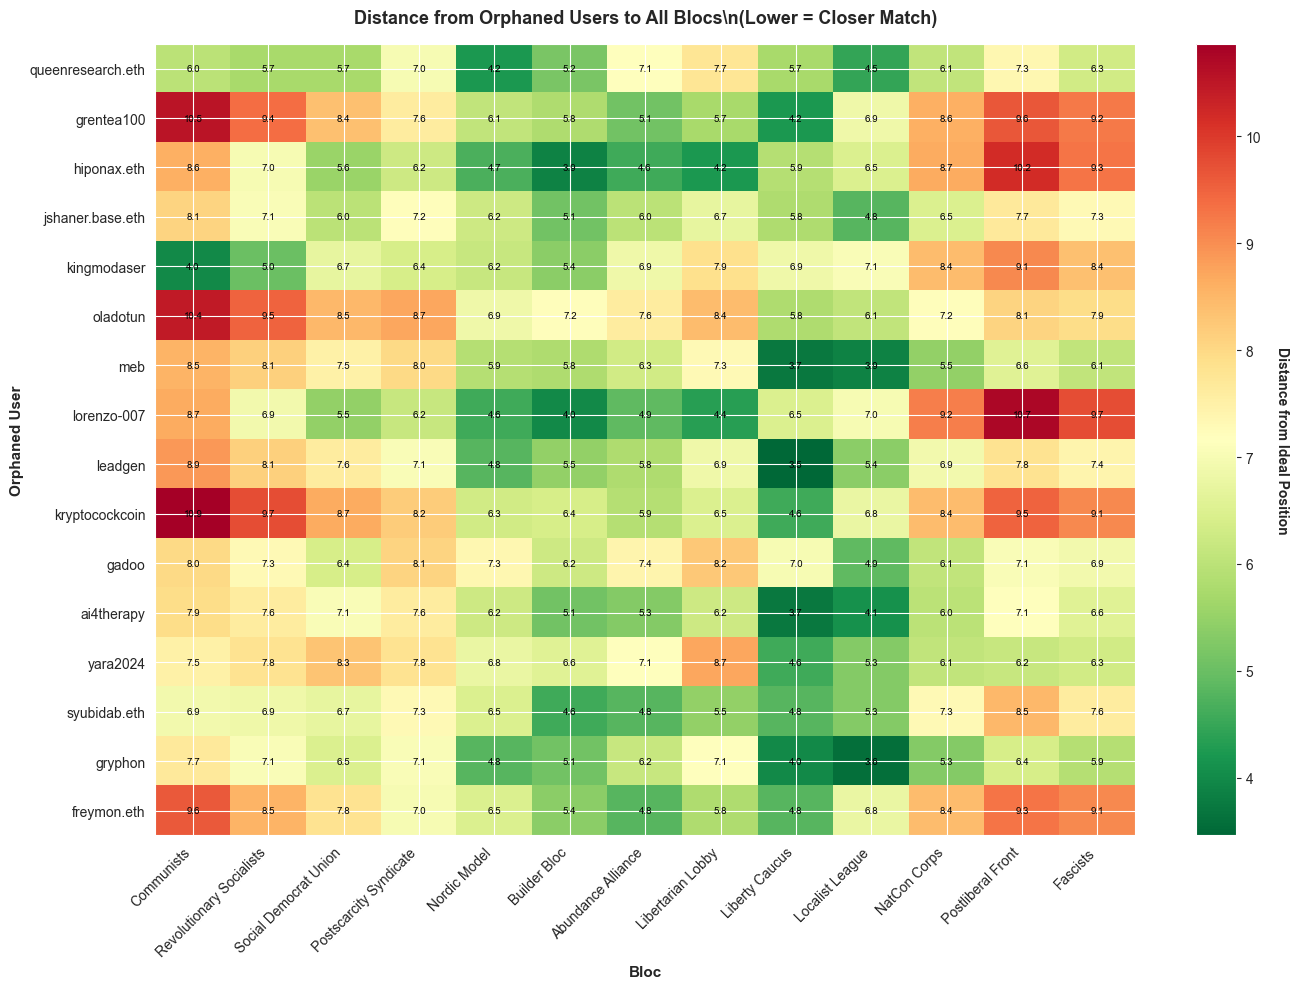

\n======================================================================
✅ Bloc positioning analysis complete!


In [9]:
# Analyze positioning of orphaned users relative to all blocs
# Calculate Euclidean distance from each orphaned user to each bloc

def calculate_distances_to_blocs(user_row):
    """Calculate Euclidean distance from user to all blocs"""
    dim_map = {
        'trade': 'trade_score',
        'abortion': 'abortion_score',
        'migration': 'migration_score',
        'economics': 'economics_score',
        'rights': 'rights_score',
    }
    
    distances = {}
    for bloc_id in bloc_ids:
        ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
        bloc_name = BLOC_NAMES.get(bloc_id, bloc_id)
        
        # Calculate Euclidean distance
        sum_squared_diffs = 0
        for dim in ['trade', 'abortion', 'migration', 'economics', 'rights']:
            score_field = f'{dim}_score'
            user_score = user_row[dim_map[dim]]
            ideal_score = ideal_pos[score_field]
            sum_squared_diffs += (user_score - ideal_score) ** 2
        
        distance = np.sqrt(sum_squared_diffs)
        distances[bloc_name] = distance
    
    return distances

print("=" * 70)
print("ORPHANED USERS: BLOC POSITIONING ANALYSIS")
print("=" * 70)
print("\n📍 Showing which blocs each orphaned user fits between\\n")
print("   (Displaying closest 3 blocs for each user)")
print("=" * 70)

# Analyze each orphaned user
for idx, user_row in orphaned_users.iterrows():
    username = user_row['username']
    user_scores = f"[T={user_row['trade_score']}, A={user_row['abortion_score']}, M={user_row['migration_score']}, E={user_row['economics_score']}, R={user_row['rights_score']}]"
    
    # Calculate distances to all blocs
    distances = calculate_distances_to_blocs(user_row)
    
    # Sort by distance and get top 3 closest
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    closest_3 = sorted_distances[:3]
    
    print(f"\\n👤 {username} {user_scores}")
    print(f"   Positioned between:")
    for rank, (bloc_name, distance) in enumerate(closest_3, 1):
        # Get ideal position for context
        bloc_id = next((bid for bid, bname in BLOC_NAMES.items() if bname == bloc_name), None)
        if bloc_id:
            ideal_pos = IDEAL_BLOC_POSITIONS[bloc_id]
            ideal_str = f"[{ideal_pos['trade_score']},{ideal_pos['abortion_score']},{ideal_pos['migration_score']},{ideal_pos['economics_score']},{ideal_pos['rights_score']}]"
            print(f"      {rank}. {bloc_name:25} (distance: {distance:.2f}, ideal: {ideal_str})")

# Create visualization showing orphaned users and their closest blocs
print(f"\\n{'='*70}")
print("📊 Creating distance heatmap...")
print(f"{'='*70}")

# Create a matrix of orphaned users vs all blocs
orphaned_usernames = orphaned_users['username'].tolist()
bloc_names_list = [BLOC_NAMES[bid] for bid in bloc_ids]

distance_matrix = np.zeros((len(orphaned_usernames), len(bloc_names_list)))

for i, (idx, user_row) in enumerate(orphaned_users.iterrows()):
    distances = calculate_distances_to_blocs(user_row)
    for j, bloc_name in enumerate(bloc_names_list):
        distance_matrix[i, j] = distances[bloc_name]

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(distance_matrix, cmap='RdYlGn_r', aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(bloc_names_list)))
ax.set_yticks(np.arange(len(orphaned_usernames)))
ax.set_xticklabels(bloc_names_list, rotation=45, ha='right')
ax.set_yticklabels(orphaned_usernames)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Distance from Ideal Position', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(orphaned_usernames)):
    for j in range(len(bloc_names_list)):
        text = ax.text(j, i, f'{distance_matrix[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=7)

ax.set_title('Distance from Orphaned Users to All Blocs\\n(Lower = Closer Match)', 
            fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Bloc', fontsize=11, fontweight='bold')
ax.set_ylabel('Orphaned User', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\\n{'='*70}")
print("✅ Bloc positioning analysis complete!")
print(f"{'='*70}")

## Bloc Coverage Summary

In [10]:
total_users = len(df)

# Ensure required columns exist (avoid re-creating if already exists)
if 'in_any_bloc' not in df.columns:
    df['in_any_bloc'] = df[bloc_columns].any(axis=1)
if 'bloc_count' not in df.columns:
    df['bloc_count'] = df[bloc_columns].sum(axis=1)

orphaned = (~df['in_any_bloc']).sum()
multi_bloc = (df['bloc_count'] > 1).sum()
single_bloc = (df['bloc_count'] == 1).sum()

print("=" * 70)
print("BLOC COVERAGE SUMMARY")
print("=" * 70)
print(f"\\nTotal Users: {total_users}")
print(f"\\nCoverage:")
print(f"  ✓ In at least one bloc: {total_users-orphaned} ({(total_users-orphaned)/total_users*100:.1f}%)")
print(f"  ✗ Orphaned (no bloc): {orphaned} ({orphaned/total_users*100:.1f}%)")
print(f"\\nOverlap:")
print(f"  • Exactly one bloc: {single_bloc} ({single_bloc/total_users*100:.1f}%)")
print(f"  • Multiple blocs: {multi_bloc} ({multi_bloc/total_users*100:.1f}%)")
print(f"  • Max blocs per user: {df['bloc_count'].max()}")

# Create bloc_df DataFrame (THIS WAS MISSING!)
bloc_data = []
for col in bloc_columns:
    bloc_name = BLOC_NAMES[col]
    count = df[col].sum()
    pct = (count / total_users) * 100
    avg_other = df[df[col]]['bloc_count'].mean() if count > 0 else 0
    bloc_data.append({
        'Bloc': bloc_name, 
        'Count': count, 
        'Percentage': pct, 
        'Avg_Blocs_Per_User': avg_other
    })

bloc_df = pd.DataFrame(bloc_data)

# Print the table
print(f"\\n{'Bloc':<25} {'Members':<10} {'% of Total':<12} {'Avg Blocs/User'}")
print("-" * 70)
for _, row in bloc_df.iterrows():
    print(f"{row['Bloc']:<25} {row['Count']:<10} {row['Percentage']:>6.1f}%      {row['Avg_Blocs_Per_User']:>5.2f}")

print("\\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

orphan_pct = (orphaned / total_users) * 100
if orphan_pct > 20:
    print("\\n⚠️  HIGH ORPHAN RATE: >20% don't fit any bloc")
elif orphan_pct > 10:
    print("\\n⚡ MODERATE ORPHAN RATE: 10-20% don't fit any bloc")
else:
    print("\\n✅ GOOD COVERAGE: <10% orphaned users")

multi_pct = (multi_bloc / total_users) * 100
if multi_pct > 50:
    print("\\n⚠️  HIGH OVERLAP: >50% in multiple blocs")
elif multi_pct > 30:
    print("\\n⚡ MODERATE OVERLAP: 30-50% in multiple blocs")
else:
    print("\\n✅ GOOD EXCLUSIVITY: <30% in multiple blocs")

small_blocs = bloc_df[bloc_df['Count'] < total_users * 0.05]
if len(small_blocs) > 0:
    print(f"\\n⚡ SMALL BLOCS: {len(small_blocs)} bloc(s) <5% membership")

large_blocs = bloc_df[bloc_df['Percentage'] > 40]
if len(large_blocs) > 0:
    print(f"\\n⚡ DOMINANT BLOCS: {len(large_blocs)} bloc(s) >40% membership")

print("\\n" + "=" * 70)

BLOC COVERAGE SUMMARY
\nTotal Users: 91
\nCoverage:
  ✓ In at least one bloc: 75 (82.4%)
  ✗ Orphaned (no bloc): 16 (17.6%)
\nOverlap:
  • Exactly one bloc: 24 (26.4%)
  • Multiple blocs: 51 (56.0%)
  • Max blocs per user: 5
\nBloc                      Members    % of Total   Avg Blocs/User
----------------------------------------------------------------------
Communists                0             0.0%       0.00
Revolutionary Socialists  2             2.2%       3.00
Social Democrat Union     10           11.0%       3.60
Postscarcity Syndicate    23           25.3%       3.48
Nordic Model              36           39.6%       2.86
Builder Bloc              38           41.8%       2.97
Abundance Alliance        26           28.6%       2.77
Libertarian Lobby         17           18.7%       3.06
Liberty Caucus            9             9.9%       1.67
Localist League           7             7.7%       1.43
NatCon Corps              2             2.2%       2.50
Postliberal Front    

## Orphaned Users Analysis

Orphaned Users: 16 (17.6%)
\nOrphaned users:
  @queenresearch.eth: T=3, A=0, M=5, E=3, R=4
  @grentea100: T=0, A=5, M=4, E=1, R=0
  @hiponax.eth: T=3, A=1, M=3, E=0, R=0
  @jshaner.base.eth: T=4, A=5, M=3, E=2, R=0
  @kingmodaser: T=3, A=0, M=0, E=4, R=6
  @oladotun: T=1, A=6, M=6, E=3, R=0
  @meb: T=2, A=5, M=5, E=2, R=2
  @lorenzo-007: T=3, A=0, M=3, E=0, R=0
  @leadgen: T=0, A=4, M=5, E=3, R=2
  @kryptocockcoin: T=0, A=5, M=5, E=1, R=0
  @gadoo: T=5, A=6, M=3, E=3, R=0
  @ai4therapy: T=3, A=5, M=3, E=1, R=2
  @yara2024: T=1, A=6, M=3, E=5, R=4
  @syubidab.eth: T=4, A=3, M=1, E=0, R=3
  @gryphon: T=2, A=4, M=5, E=3, R=2
  @freymon.eth: T=1, A=6, M=2, E=2, R=0
\nOrphaned User Statistics:
------------------------------------------------------------
Trade           Avg: 2.19
Abortion        Avg: 3.81
Migration       Avg: 3.50
Economics       Avg: 2.06
Rights          Avg: 1.56


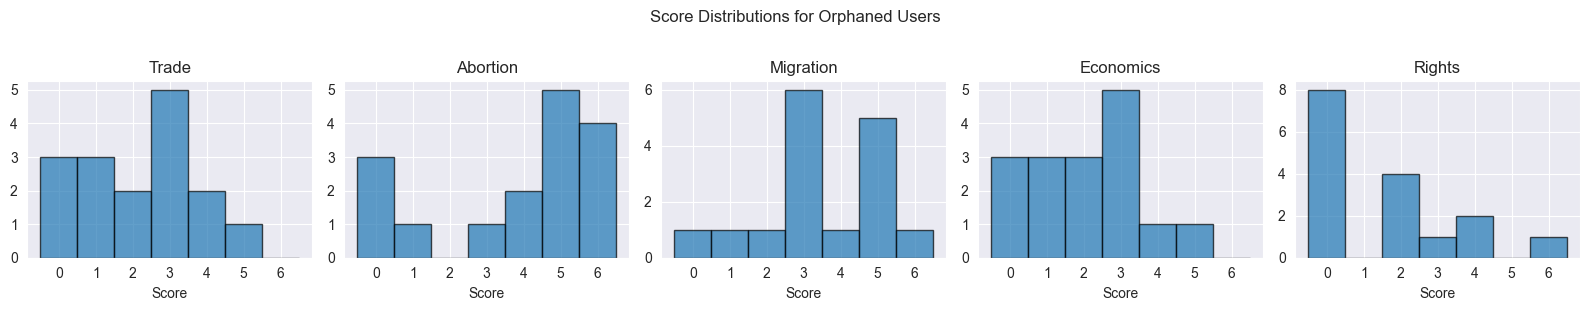

In [11]:
# Use existing orphaned users data
orphaned = df[~df['in_any_bloc']].copy()

print(f"Orphaned Users: {len(orphaned)} ({len(orphaned)/len(df)*100:.1f}%)")
print("="*70)

if len(orphaned) > 0:
    print(f"\\nOrphaned users:")
    for idx, row in orphaned.iterrows():
        print(f"  @{row['username']}: T={row['trade_score']}, A={row['abortion_score']}, M={row['migration_score']}, E={row['economics_score']}, R={row['rights_score']}")
    
    print(f"\\nOrphaned User Statistics:")
    print("-" * 60)
    for dim in dimensions:
        print(f"{dim.replace('_score', '').title():<15} Avg: {orphaned[dim].mean():.2f}")
    
    # Distribution
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    for idx, dim in enumerate(dimensions):
        axes[idx].hist(orphaned[dim], bins=7, range=(-0.5, 6.5), alpha=0.7, edgecolor='black')
        axes[idx].set_title(dim.replace('_score', '').title())
        axes[idx].set_xlabel('Score')
        axes[idx].set_xticks(range(7))
    plt.suptitle('Score Distributions for Orphaned Users', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\\n✅ No orphaned users!")

## Bloc Overlap Analysis

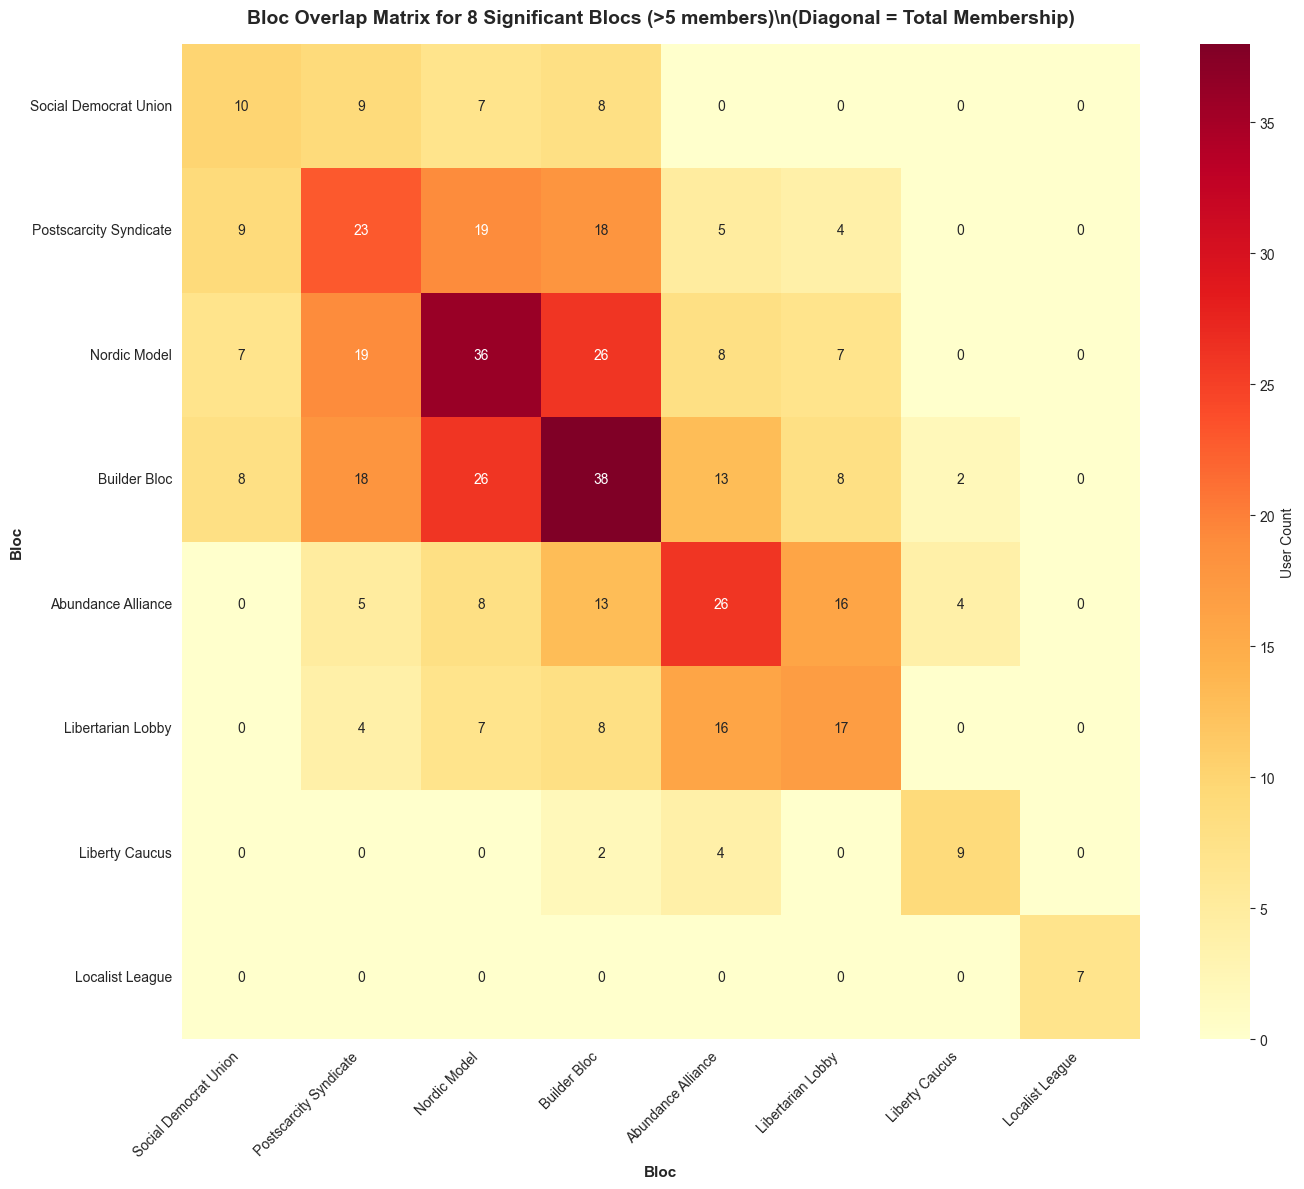

\n📊 Showing overlap for 8 blocs with >5 members
   (Excluded 5 small blocs for clarity)


In [12]:
# Create overlap matrix for blocs with significant membership (>5 members)
significant_blocs = bloc_df[bloc_df['Count'] > 5]['Bloc'].tolist()
sig_bloc_ids = [bid for bid in bloc_ids if BLOC_NAMES.get(bid, bid) in significant_blocs]

if len(sig_bloc_ids) > 0:
    overlap_matrix = pd.DataFrame(index=[BLOC_NAMES[bid] for bid in sig_bloc_ids], 
                                  columns=[BLOC_NAMES[bid] for bid in sig_bloc_ids], 
                                  dtype=int)
    
    for bloc1_id in sig_bloc_ids:
        bloc1_name = BLOC_NAMES[bloc1_id]
        for bloc2_id in sig_bloc_ids:
            bloc2_name = BLOC_NAMES[bloc2_id]
            if bloc1_name == bloc2_name:
                overlap_matrix.loc[bloc1_name, bloc2_name] = df[bloc1_id].sum()
            else:
                overlap_matrix.loc[bloc1_name, bloc2_name] = (df[bloc1_id] & df[bloc2_id]).sum()
    
    overlap_matrix = overlap_matrix.astype(int)
    
    # Heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(overlap_matrix, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'User Count'})
    plt.title(f'Bloc Overlap Matrix for {len(sig_bloc_ids)} Significant Blocs (>5 members)\\n(Diagonal = Total Membership)', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Bloc', fontsize=11, fontweight='bold')
    plt.ylabel('Bloc', fontsize=11, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\\n📊 Showing overlap for {len(sig_bloc_ids)} blocs with >5 members")
    print(f"   (Excluded {len(bloc_ids) - len(sig_bloc_ids)} small blocs for clarity)")
else:
    print("No blocs with sufficient membership for overlap analysis")

## Bloc System Quality Report

In [13]:
# Prepare data
df['blocs'] = df.apply(lambda row: [BLOC_NAMES[col] for col in bloc_columns if row[col]], axis=1)

orphaned_count = (~df['in_any_bloc']).sum()
users_in_any_bloc = df['in_any_bloc'].sum()
exclusive_users = (df['bloc_count'] == 1).sum()
multi_bloc_users = (df['bloc_count'] > 1).sum()

print("="*70)
print("BLOC SYSTEM QUALITY REPORT")
print("="*70)

coverage_rate = (users_in_any_bloc / total_users) * 100
avg_memberships = df['blocs'].apply(len).mean()

print(f"\\n📊 Coverage Metrics:")
print(f"   • Total users: {total_users:,}")
print(f"   • In at least one bloc: {users_in_any_bloc:,} ({coverage_rate:.1f}%)")
print(f"   • Orphaned: {orphaned_count:,} ({orphaned_count/total_users*100:.1f}%)")

print(f"\\n🎯 Coherence Metrics:")
print(f"   • Avg blocs per member: {avg_memberships:.2f}")
print(f"   • Exclusive members (1 bloc): {exclusive_users:,} ({exclusive_users/users_in_any_bloc*100:.1f}%)")
print(f"   • Multi-bloc members: {multi_bloc_users:,} ({multi_bloc_users/users_in_any_bloc*100:.1f}%)")

quality_score = (coverage_rate * 0.4) + ((exclusive_users / users_in_any_bloc * 100) * 0.3) + ((users_in_any_bloc / total_users * 100) * 0.3)

print(f"\\n⭐ Overall Quality Score: {quality_score:.1f}/100")
print(f"   (40% coverage + 30% exclusivity + 30% capture)")
print("\\n" + "="*70)

BLOC SYSTEM QUALITY REPORT
\n📊 Coverage Metrics:
   • Total users: 91
   • In at least one bloc: 75 (82.4%)
   • Orphaned: 16 (17.6%)
\n🎯 Coherence Metrics:
   • Avg blocs per member: 1.88
   • Exclusive members (1 bloc): 24 (32.0%)
   • Multi-bloc members: 51 (68.0%)
\n⭐ Overall Quality Score: 67.3/100
   (40% coverage + 30% exclusivity + 30% capture)
\n======================================================================


## Visualization Dashboard

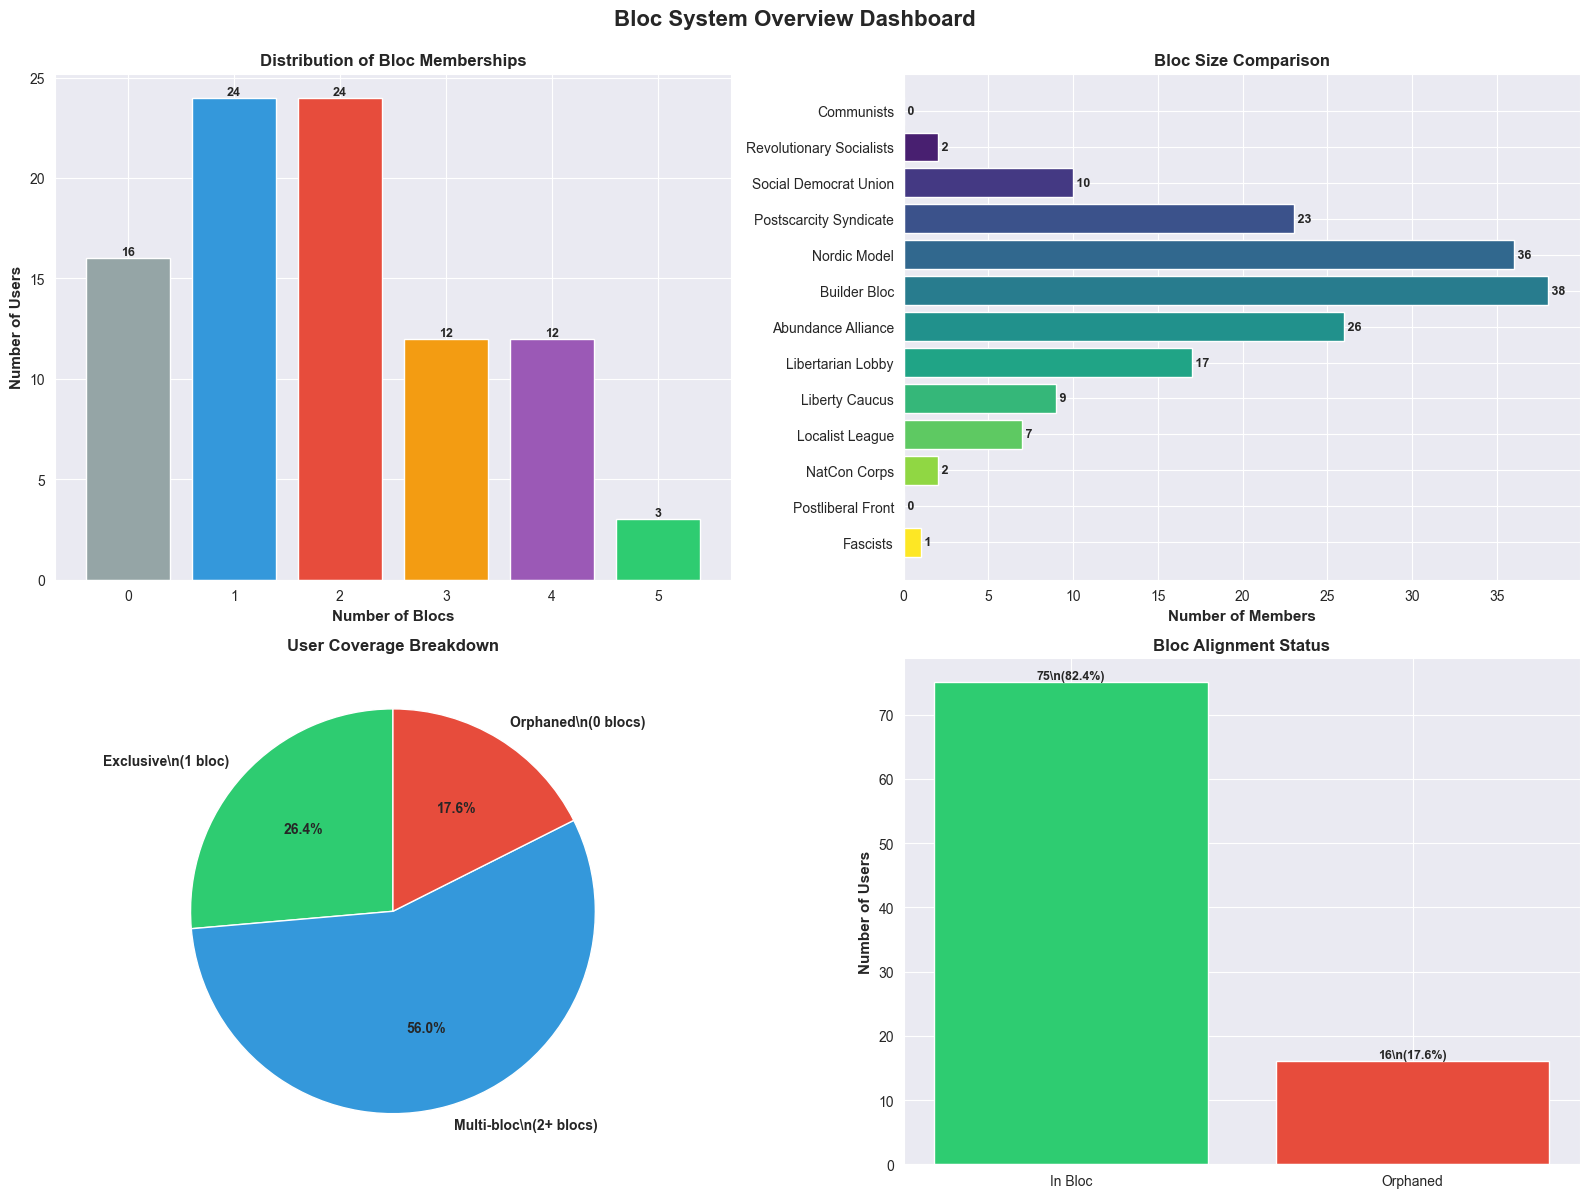

\n✅ Bloc exploration complete!


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Membership count distribution
membership_counts = df['blocs'].apply(len).value_counts().sort_index()
ax1 = axes[0, 0]
bars = ax1.bar(membership_counts.index, membership_counts.values, color=['#95a5a6', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71'])
ax1.set_xlabel('Number of Blocs', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Bloc Memberships', fontsize=12, fontweight='bold')
ax1.set_xticks(range(0, max(membership_counts.index) + 1))
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Bloc size comparison
ax2 = axes[0, 1]
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(bloc_df)))
bars = ax2.barh(bloc_df['Bloc'], bloc_df['Count'], color=colors_bar)
ax2.set_xlabel('Number of Members', fontsize=11, fontweight='bold')
ax2.set_title('Bloc Size Comparison', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2., f' {int(width):,}', ha='left', va='center', fontsize=9, fontweight='bold')

# 3. Coverage breakdown (pie)
ax3 = axes[1, 0]
coverage_data = {'Exclusive\\n(1 bloc)': exclusive_users, 'Multi-bloc\\n(2+ blocs)': multi_bloc_users, 'Orphaned\\n(0 blocs)': orphaned_count}
colors_pie = ['#2ecc71', '#3498db', '#e74c3c']
ax3.pie(coverage_data.values(), labels=coverage_data.keys(), autopct='%1.1f%%', colors=colors_pie, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('User Coverage Breakdown', fontsize=12, fontweight='bold')

# 4. Alignment status
ax4 = axes[1, 1]
alignment_data = {'In Bloc': users_in_any_bloc, 'Orphaned': orphaned_count}
colors_align = ['#2ecc71', '#e74c3c']
bars = ax4.bar(range(len(alignment_data)), alignment_data.values(), color=colors_align)
ax4.set_xticks(range(len(alignment_data)))
ax4.set_xticklabels(alignment_data.keys(), fontsize=10)
ax4.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax4.set_title('Bloc Alignment Status', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}\\n({height/total_users*100:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Bloc System Overview Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\\n✅ Bloc exploration complete!")